In [1]:
import popalign as PA
import importlib
import pickle

import numpy as np
from multiprocessing import Pool
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import os
from scipy.special import comb
import scipy.cluster.hierarchy as hc
import scipy.spatial as sp

import numpy as np
from matplotlib import pyplot as plt

/Users/sisichen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import anndata as ad

In [3]:
### import anndata version of the data

In [6]:
adata = ad.read_h5ad('all_datasets.h5ad')

In [7]:
# convert adata to pop object: 
pop = dict
meta = adata.obs
M = adata.X.T.tocsc()
controlstring = 'Nat'
genes = adata.var_names
outputfolder = 'output'

samples = adata.obs['orig.ident'].cat.categories
samples = ['2D', 'D5', 'D6', 'Nat','StemBlastoids', 'iBlastoids']

pop = {}
pop['samples'] = {}
pop['order'] = []
pop['controlstring'] = controlstring
pop['genes'] = genes
pop['ncores'] = None

cols = meta.columns.values

barcodes = adata.obs.index
bc_idx = {} # store index of each barcode in a dictionary to quickly retrieve indices for a list of barcodes
for i, bc in enumerate(barcodes):
    bc_idx[bc] = i

accum_idx = [] # accumulate index values for subsetted samples
for i, x in enumerate(samples):
    if x !='unknown':
        print(x)
        pop['samples'][x]={}
        sample_bcs = meta[meta['orig.ident'] == x].index
        idx = [bc_idx[bc] for bc in sample_bcs]
        pop['samples'][x]['M'] = M[:,idx] # extract matching data from M
        pop['order'].append(x) # save list of sample names to always call them in the same order for consistency
        accum_idx = accum_idx + idx 
        # store cell type information in samples 
        if 'type' in cols: 
            pop['samples'][x]['cell_type'] = meta.iloc[idx].type.tolist() # extract supplied cell types from metadata
            

# Trim the meta data file to only contain the filtered samples
currmeta = meta.iloc[accum_idx]
pop['meta'] = currmeta

# save start and end of cell indices of sample relative to other samples
start = 0
end = 0
for x in pop['order']:
    n = pop['samples'][x]['M'].shape[1]
    end = start+n
    pop['samples'][x]['indices'] = (start,end)
    start = end
pop['ncells'] = end
pop['nsamples'] = len(pop['order']) 
pop['output'] = outputfolder

2D
D5
D6
Nat
StemBlastoids
iBlastoids


In [8]:
pop.keys()

dict_keys(['samples', 'order', 'controlstring', 'genes', 'ncores', 'meta', 'ncells', 'nsamples', 'output'])

In [9]:
# read in the marker genes: 
# markers = pd.read_csv('../../Resources/markers.csv', header = 0)
markers = pd.read_csv('markers.csv', header = 0)
markers = markers.iloc[:,0:2]

In [10]:
markers

,Lineage,Gene
0,Naive,KLF4
1,Naive,KLF17
2,Naive,PRDM14
3,Naive,DNMT3L
4,Naive,SOX15
...,...,...
109,Amnion,KRT19
110,Amnion,TPM1
111,Amnion,RARRES2
112,Amnion,MSX2


In [11]:
'''
Display number of cells in each sample, total number of cells

Parameters
----------
pop : dict
    Popalign object
'''
PA.print_ncells(pop)

2D 	 228
D5 	 2013
D6 	 2057
Nat 	 542
StemBlastoids 	 4497
iBlastoids 	 6735
Total number of cells loaded: 16072


In [12]:
'''
Normalize the samples of object `pop` and applies a normalization factor

Parameters
----------
pop : dict
    Popalign object
scaling_factor : int or None, optional
    Number used to scale the data values. If None, that factor is computed automatically
ncells : int or None
    Number of cells to randomly subsample to try different normalization factors to use less memory. If None, all cells are used.
'''
PA.normalize(pop, scaling_factor=None, ncells=None)

Performing column normalization
Finding best scaling factor
Best scaling factor beta is: 10000


1834 genes selected


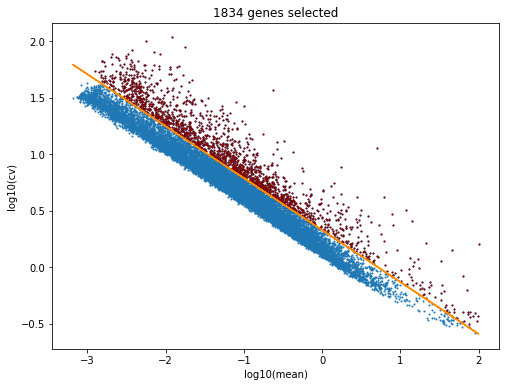

In [13]:
'''
Plot genes by their log(mean) and log(coefficient of variation)
Can be used multiple times to find best offset

Parameters
----------
offset: float
    Value (its log) will be added to the intercept of the linear fit to filter genes
'''

PA.plot_gene_filter(pop, offset=1.3)

In [14]:
# # Make sure all markers are in the filtered_idx <- this will be used to filter genes in the next step 

def addmarkers(pop, markerlist): 
    '''
    Add specific markers back to the list after the filter(pop) step. 
    
    Parameters
    ----------
    pop : dict
        Popalign object
    markerlist : list
        list of genes that should be kept in the analysis
    '''
    
    M = PA.cat_data(pop,'M')
    allmarkeridx = []
    for i, marker in enumerate(markerlist):
        midx = np.nonzero(np.array(pop['genes'])==marker)[0]
        # check that marker is not zero across all cells
        if np.sum(M[midx,:])==0: 
            # do not add the marker
            print('marker ' + marker +' has 0 transcripts')
        else: 
            allmarkeridx.append(midx)
    allmarkeridx = np.hstack(allmarkeridx)

    filter_idx = pop['filter_idx']
    filter_idx = np.sort(np.union1d(filter_idx,allmarkeridx))

    numgenesadded = len(filter_idx) - len(pop['filter_idx'])
    print('Number of genes added: ' + str(numgenesadded))
    
    pop['filter_idx'] = filter_idx 


In [15]:
markerlist = markers['Gene']
addmarkers(pop,markerlist)

marker HNF1B has 0 transcripts
marker LINC01356 has 0 transcripts
Number of genes added: 60


In [16]:
len(pop['filter_idx'])

1894

In [17]:
'''
Filter genes from data in `pop`
Can discard ribosomal genes that start with RPS or RPL
Can discard mitochondrial genes that start with MT-

Parameters
----------
pop :dict
    Popalign object
remove_ribsomal : bool
    Wether to remove or not the ribosomal genes
remove_mitochondrial : bool
    Wether to remove or not the mitochondrial geneset
'''
PA.filter(pop, remove_ribsomal=False, remove_mitochondrial=False)

Filtering genes and logging data


In [18]:
print(pop['samples']['2D']['M'].shape)

(18379, 228)


### Do NMF to see what the different cell types are: 

In [19]:
from sklearn import cluster as scluster
from scipy import sparse as ss
from scipy import optimize as so

def plot_top_genes_features(W, genes, stdfactor=3, prefix=''):
    """
    Plot heatmap top genes per feature ~ features

    NB: Currently only supports oNMF features

    Parameters
    ----------
    W: array
        m (number of genes) x k (number of features)
    genes: list of strings
        gene names
    stdfactor: float 
        factor to select genes
    """
    filtered_genes = genes
    nfeats = W.shape[1]
    stds = np.array(W.std(axis=0)).flatten() # get the feature standard deviations
     
    genes_idx = np.array([])
    genes_loadings = np.array([])
    genes_featv = np.array([]) # keep track of which feature we are on
    for i,s in enumerate(stds): # for each feature i and its respective standard deviations
        a = np.where(np.array(W[:,i]).flatten() > stdfactor*s)[0] # get indices of top genes
        sub = np.array(W[a,i]).flatten() # grab coefficients of top genes for feature i
        a = a[np.argsort(sub)[::-1]] # sort subset by coefficent
        genes_idx = np.concatenate([genes_idx, a]) # concatenate gene indices
        genes_loadings = np.concatenate([genes_loadings, np.sort(sub)[::-1]])
        genes_featv = np.concatenate([genes_featv, [i]*len(a)])
    genes_idx = genes_idx.astype(int)

    # make list unique (a gene can't appear twice in the list for two different features)
    s = set() # set of genes currently kept
    l = [] # list of genes
    vals = [] # value of maximum loading seen for that gene 
    keepidx = []
    for i in range(len(genes_idx)):
        x = genes_idx[i]
        currval = genes_loadings[i]
        curridx = np.nonzero(genes_loadings==currval)[0][0]
        if x in s: 
            # find the existing loading value and compare it to the new loading value
            origidx = np.argwhere(l==x)[0][0]
            origval = vals[origidx]
            if origval<currval: 
                # remove the origval and gene name in the list and append the new val and gene name
                del keepidx[origidx]
                keepidx.append(curridx)
                l.remove(x)
                l.append(x)
                vals.remove(origval)
                vals.append(currval)

        if x not in s:
            s.add(x)
            l.append(x)
            vals.append(currval)
            keepidx.append(curridx)

    genes_idx = np.array(l)[::-1]
    genes_featv = np.flipud(genes_featv[keepidx])
    keptgenes = [filtered_genes[i] for i in genes_idx]
    
     # define gene font sizes
    geneFS = 3 # (default)
    if len(genes_idx)>200: 
        geneFS = 4
    if len(genes_idx)>400: 
        geneFS = 2
    if len(genes_idx)>600: 
        geneFS = 1

    mtx = W[genes_idx, :] # subset feature space with the top genes for the features
    
    fig = plt.figure(figsize=(8,16))
    ax1 = plt.subplot2grid((5,50), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((5,50), (0,1), rowspan=5, colspan=49)

    ax1.imshow(genes_featv.reshape((len(genes_featv),1)), cmap='tab20', aspect = 'auto')
    ax1.set_xticks([])
    ax1.set_ylabel('Genes')
    ax1.set_ylim(-0.5,len(genes_idx)-0.5)
    ax1.set_yticks(np.arange(len(genes_idx)))
    ax1.set_yticklabels(keptgenes, fontsize=geneFS)
    
    ar = 3 * nfeats/len(genes_idx) # define aspect ratio
    ax2.imshow(np.flipud(mtx), cmap='magma', aspect=ar, interpolation='none') # create heatmap
    xlbls = [i for i in range(nfeats)]
    ax2.set_yticks([])
    ax2.set_xticks(np.arange(nfeats))
    ax2.set_xticklabels(xlbls, rotation=45, ha='right',fontsize=6)
    ax2.set_xlabel('Features')
    
    plt.savefig((pop['output']+'/'+ prefix +'_features_m%d_topgenes.pdf' % W.shape[1]), dpi=600, bbox_inches = "tight")
    plt.close()
    
    return genes_idx, genes_featv


### Run NMF de novo and look for gene programs: 


In [20]:
# find nmf features using a random subset of cells
import random
M_norm = PA.cat_data(pop,'M_norm')
randidx = random.sample(range(M_norm.shape[1]),5000)
numfeatures = 17

M_sample = M_norm[:,randidx]

# remove all zero genes
keepidx = np.nonzero(np.sum(M_sample,axis=1)>0)[0]
M_sample = M_sample[keepidx,:]
NMFgenes = np.array(pop['filtered_genes'])[keepidx]

W, H =  PA.oNMF(M_norm[:,randidx], numfeatures)

Orthogonal NMF performed with 500 iterations



In [216]:
# [MANUAL STEP: reorganize the W vectors]
W_reorg_idx = [6,11,15,13,1,0,2,4,10, #universal
               12,# D5 synthetic enriched
               3, # D6 synthetic enriched
               5,7,9,8,14] #natural enriched
W = W[:,W_reorg_idx]

In [241]:
feat_gidx, featv = plot_top_genes_features(W, NMFgenes, stdfactor=2)

In [218]:
# get indices for genes
plot_genes = NMFgenes[feat_gidx]

### Generate cell reordering vectors based on 1) hierarchical clustering and 2) cell type labels

In [203]:
def class2num(classes, classorder = None):
    '''
    convert class array into numbers for plotting
    classes : array of strings
        vector of classes, which is the same variable as the data
    classorder: array of strings
        
    '''
    if classorder==None: 
        classorder = list(dict.fromkeys(classes))
    else: 
        if not(set(classorder)==set(classes)):
            raise Exception('classorder must contain all classes')
    
    classdict = {classorder[i]:i for i in range(len(classorder))}
    classnums = np.array([classdict[c] for c in classes])

    return classnums, classdict    

In [204]:
classnums, classdict = class2num(pop['meta']['type'], ['EPI', 'HYPO', 'IM', 'PE', 'TE', 'undefined'])

In [205]:
list(classdict.keys())

['EPI', 'HYPO', 'IM', 'PE', 'TE', 'undefined']

In [206]:
# [1] Generate cell indices based on unsupervised hierarchical clustering

keys = ['D5','D6','2D','Nat', 'StemBlastoids', 'iBlastoids']
max_d = 0.5

cellidxlist=[]

for key in keys: 
    currM = ss.hstack([pop['samples'][x]['M_norm'] for x in pop['order'] if (key in x)])
    # cluster the cells: 
    cc = pd.DataFrame(currM.todense()).corr()
    d = 1 -  cc
    Z = hc.linkage(sp.distance.squareform(d), method='complete')

    # clusters = hc.fcluster(Z, max_d, criterion='distance').flatten()
    currcellidx = hc.leaves_list(Z)
    cellidxlist.append(currcellidx)
    print(key + ' done')

D5 done
D6 done
2D done
Nat done
StemBlastoids done
iBlastoids done


In [207]:
# [2] Generate cell indices based on supplied cell type labels 

keys = ['D5','D6','2D','Nat', 'StemBlastoids', 'iBlastoids']

cellidxlist_labels=[]
for key in keys: 
    sampidx = np.array([i for i in range(len(pop['meta'])) if key in pop['meta']['orig.ident'].iloc[i]])
    cellidx = []
    for i, class_type in enumerate(classdict.keys()):
        curridx = np.nonzero(classnums[sampidx]==i)[0]
        cellidx.append(curridx)
    cellidx = np.hstack(cellidx)    
    cellidxlist_labels.append(cellidx)
    print(key + ' done')

D5 done
D6 done
2D done
Nat done
StemBlastoids done
iBlastoids done


In [219]:
# Make plots using the hierarchical clustering indices

keys = ['D5','D6','2D','Nat', 'StemBlastoids', 'iBlastoids']


for i,key in enumerate(keys): 
#     ax = axes[i]
    sampidx = np.array([i for i in range(len(pop['meta'])) if key in pop['meta']['orig.ident'].iloc[i]])

    # Plot everything together 
    f_cmap = plt.get_cmap('tab20', int(max(featv)+1))
    c_cmap = plt.get_cmap('Dark2', max(classnums)+1)

    cellidx =cellidxlist[i]
    
    currM = ss.hstack([pop['samples'][x]['M_norm'] for x in pop['order'] if (key in x)])
    currM = currM[keepidx[feat_gidx],:]
    
    curr_classnums = classnums[sampidx]
    
    fig = plt.figure(figsize=(8,8))
    
    ax1 = plt.subplot2grid((8,8), (0,0),  rowspan=7, colspan=1) # gene labels
    ax2 = plt.subplot2grid((8,8), (0,1),  rowspan=7, colspan=7) # M : gene exp matrix
    ax3 = plt.subplot2grid((8,8), (7,1),  rowspan=1, colspan=7) # cell types

    ax1.imshow(featv.reshape((len(featv),1)), cmap=f_cmap, aspect = 'auto')
    ax1.set_xticks([])
    ax1.set_ylabel('Genes')
    ax1.set_ylim(-0.5,len(plot_genes)-0.5)
    ax1.set_yticks(np.arange(len(plot_genes)))
    ax1.set_yticklabels(plot_genes, fontsize=2)
    
    ax2.imshow(np.flipud(currM[:,cellidx].todense()), cmap='BuPu', aspect='auto')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title(key)   
        
    cax = ax3.imshow(curr_classnums[cellidx].reshape((len(cellidx),1)).T, cmap=c_cmap,aspect='auto', vmin=0, vmax = max(classnums)+0.5)
    ax3.set_xticks([])
    ax3.set_yticks([])
    cbar = plt.colorbar(cax, orientation='horizontal',fraction=0.3, pad=0.2)
    cbar.set_ticks(np.array(range(max(classnums)+1))+0.5) 
    cbar.ax.set_xticklabels(list(classdict.keys()),rotation=90)
    
    PA.mkdir(pop['output']+'/heatmaps')
    
    plt.savefig((pop['output']+'/heatmaps/%s_gene_heatmap_hierarchical.pdf' % key), dpi=300, bbox_inches = "tight")
    plt.close()
    
    print(key + ' done')

D5 done
D6 done
2D done
Nat done
StemBlastoids done
iBlastoids done


In [220]:
# Make plots using the given cell type labels
keys = ['D5','D6','2D','Nat', 'StemBlastoids', 'iBlastoids']

for i,key in enumerate(keys): 
#     ax = axes[i]
    sampidx = np.array([i for i in range(len(pop['meta'])) if key in pop['meta']['orig.ident'].iloc[i]])

    # Plot everything together 
    f_cmap = plt.get_cmap('tab20', int(max(featv)+1))
    c_cmap = plt.get_cmap('Dark2', max(classnums)+1)

    cellidx = cellidxlist_labels[i]
    
    currM = ss.hstack([pop['samples'][x]['M_norm'] for x in pop['order'] if (key in x)])
    currM = currM[keepidx[feat_gidx],:]
    
    curr_classnums = classnums[sampidx]
    
    fig = plt.figure(figsize=(8,8))
    
    ax1 = plt.subplot2grid((8,8), (0,0),  rowspan=7, colspan=1) # gene labels
    ax2 = plt.subplot2grid((8,8), (0,1),  rowspan=7, colspan=7) # M : gene exp matrix
    ax3 = plt.subplot2grid((8,8), (7,1),  rowspan=1, colspan=7) # cell types

    ax1.imshow(featv.reshape((len(featv),1)), cmap=f_cmap, aspect = 'auto')
    ax1.set_xticks([])
    ax1.set_ylabel('Genes')
    ax1.set_ylim(-0.5,len(plot_genes)-0.5)
    ax1.set_yticks(np.arange(len(plot_genes)))
    ax1.set_yticklabels(plot_genes, fontsize=2)
    
    ax2.imshow(np.flipud(currM[:,cellidx].todense()), cmap='BuPu', aspect='auto')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title(key)   
        
    cax = ax3.imshow(curr_classnums[cellidx].reshape((len(cellidx),1)).T, cmap=c_cmap,aspect='auto', vmin=0, vmax = max(classnums)+0.5)
    ax3.set_xticks([])
    ax3.set_yticks([])
    cbar = plt.colorbar(cax, orientation='horizontal',fraction=0.3, pad=0.2)
    cbar.set_ticks(np.array(range(max(classnums)+1))+0.5) 
    cbar.ax.set_xticklabels(list(classdict.keys()),rotation=90)
    
    PA.mkdir(pop['output']+'/heatmaps')
    
    plt.savefig((pop['output']+'/heatmaps/%s_gene_heatmap_VJcluster.pdf' % key), dpi=300, bbox_inches = "tight")
    plt.close()

In [221]:
pd.DataFrame({ 'features':featv[::-1],'genes':plot_genes[::-1]}).to_csv(pop['output']+'/heatmaps/gene_list.csv')

In [222]:
len(pop['genes'])

18379

### Run GSEA on the major gene groups annotated

In [226]:
# Before running this section write in gene groups in the excel shee

heatmap_genes = pd.read_csv(pop['output']+'/heatmaps/gene_list.csv', header = 0, index_col=0)
gene_groups = list(dict.fromkeys(heatmap_genes['group']))

In [228]:
size_total = len(pop['genes'])
ngenesets=10
# PApath ='/Users/sisichen/Documents/Github/popalign/popalign/'
resourcePath = '../../Resources/'

genesetdict = {'GO': 'c5bp.npy', 
               'Reactome-all': 'ReactomePathways_all.npy', 
               'Reactome-signaling': 'ReactomePathways_signalling_broad.npy',
               'Reactome-selected': 'ReactomePathways_selected_signalling.npy'}

In [229]:
geneset = 'Reactome-signaling'
d = PA.load_dict(os.path.join(resourcePath, genesetdict[geneset]))

gsea_list =[]
for i, group in enumerate(gene_groups): # for each feature i
    print('GSEA progress: Set %d ' % ((i+1)), end='\r')
    genelist = heatmap_genes[heatmap_genes['group']==group]['genes'].tolist() # gene matching gene names
    gsea_list.append(PA.enrichment_analysis(pop, d, genelist, size_total, ngenesets)) # for that list of genes, run GSEA)


In [230]:
gsea_list

[                                         feat_labels    feat_pvals
 0        Regulation of expression of SLITs and ROBOs  4.529217e-39
 1                        Signaling by ROBO receptors  4.295222e-36
 2                                  RHOF GTPase cycle  1.828406e-05
 3                        Toll-like Receptor Cascades  2.525658e-05
 4         MAP3K8 (TPL2)-dependent MAPK1/3 activation  2.738481e-05
 5                 FBXW7 Mutants and NOTCH1 in Cancer  1.379012e-04
 6  Loss of Function of FBXW7 in Cancer and NOTCH1...  1.379012e-04
 7                      FLT3 signaling by CBL mutants  2.881878e-04
 8                Toll Like Receptor 5 (TLR5) Cascade  2.929674e-04
 9              Toll Like Receptor 10 (TLR10) Cascade  2.929674e-04,
                                          feat_labels  feat_pvals
 0                                 NCAM1 interactions    0.000007
 1                      G alpha (z) signalling events    0.000019
 2                                  Signaling by PDGF

In [233]:
for i,result in enumerate(gsea_list): 
    vals = -np.log10(result['feat_pvals'])
    plt.barh(list(range(len(vals))),np.flipud(vals))
    plt.yticks(ticks=list(range(len(vals))),labels=np.flipud(result['feat_labels']))
    plt.xlabel('-log10(p-val)')
    plt.title(gene_groups[i])
    
    plt.savefig((pop['output']+'/heatmaps/gsea_%s_%s.pdf' %(geneset, gene_groups[i])), dpi=300, bbox_inches = "tight")
    plt.close()